# Complex Systems Project #
### Antibiotic Resistance in Bacteria
##### by Maryna Borovyk and Illia Pastushok

In [36]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [37]:
params = {
    'gS': 1.0,          # Growth rate of sensitive bacteria (1/h)
    'gR': 0.65,         # Growth rate of resistant bacteria (1/h)
    'K': 1e9,           # Carrying capacity (cells)
    'lambda': 0.7,      # Conjugation rate (1/h)
    'p': 0.5,           # Probability of plasmid loss
    'd': 0.5,           # Natural death rate (1/h)
    'ES_max': 1.5,      # Max kill rate for sensitive bacteria (1/h)
    'ER_max': 1.1,      # Max kill rate for resistant bacteria (1/h)
    'AS_50': 0.25,      # Half-max effect concentration (sensitive) (μg/ml)
    'AR_50': 5.0,       # Half-max effect concentration (resistant) (μg/ml)
    'alpha': 0.15       # Antibiotic elimination rate (1/h)
}

K is max number of bacterias
there might nbe a condition hidden in equation
max population can be as y lim K
try simpler equation without horizontal


{'gS': 1.0, 'gR': 0.65, 'K': 1000000000.0, 'lambda': 0.7, 'p': 0.5, 'd': 0.5, 'ES_max': 1.5, 'ER_max': 1.1, 'AS_50': 0.25, 'AR_50': 5.0, 'A0': 4, 'tau': 12}


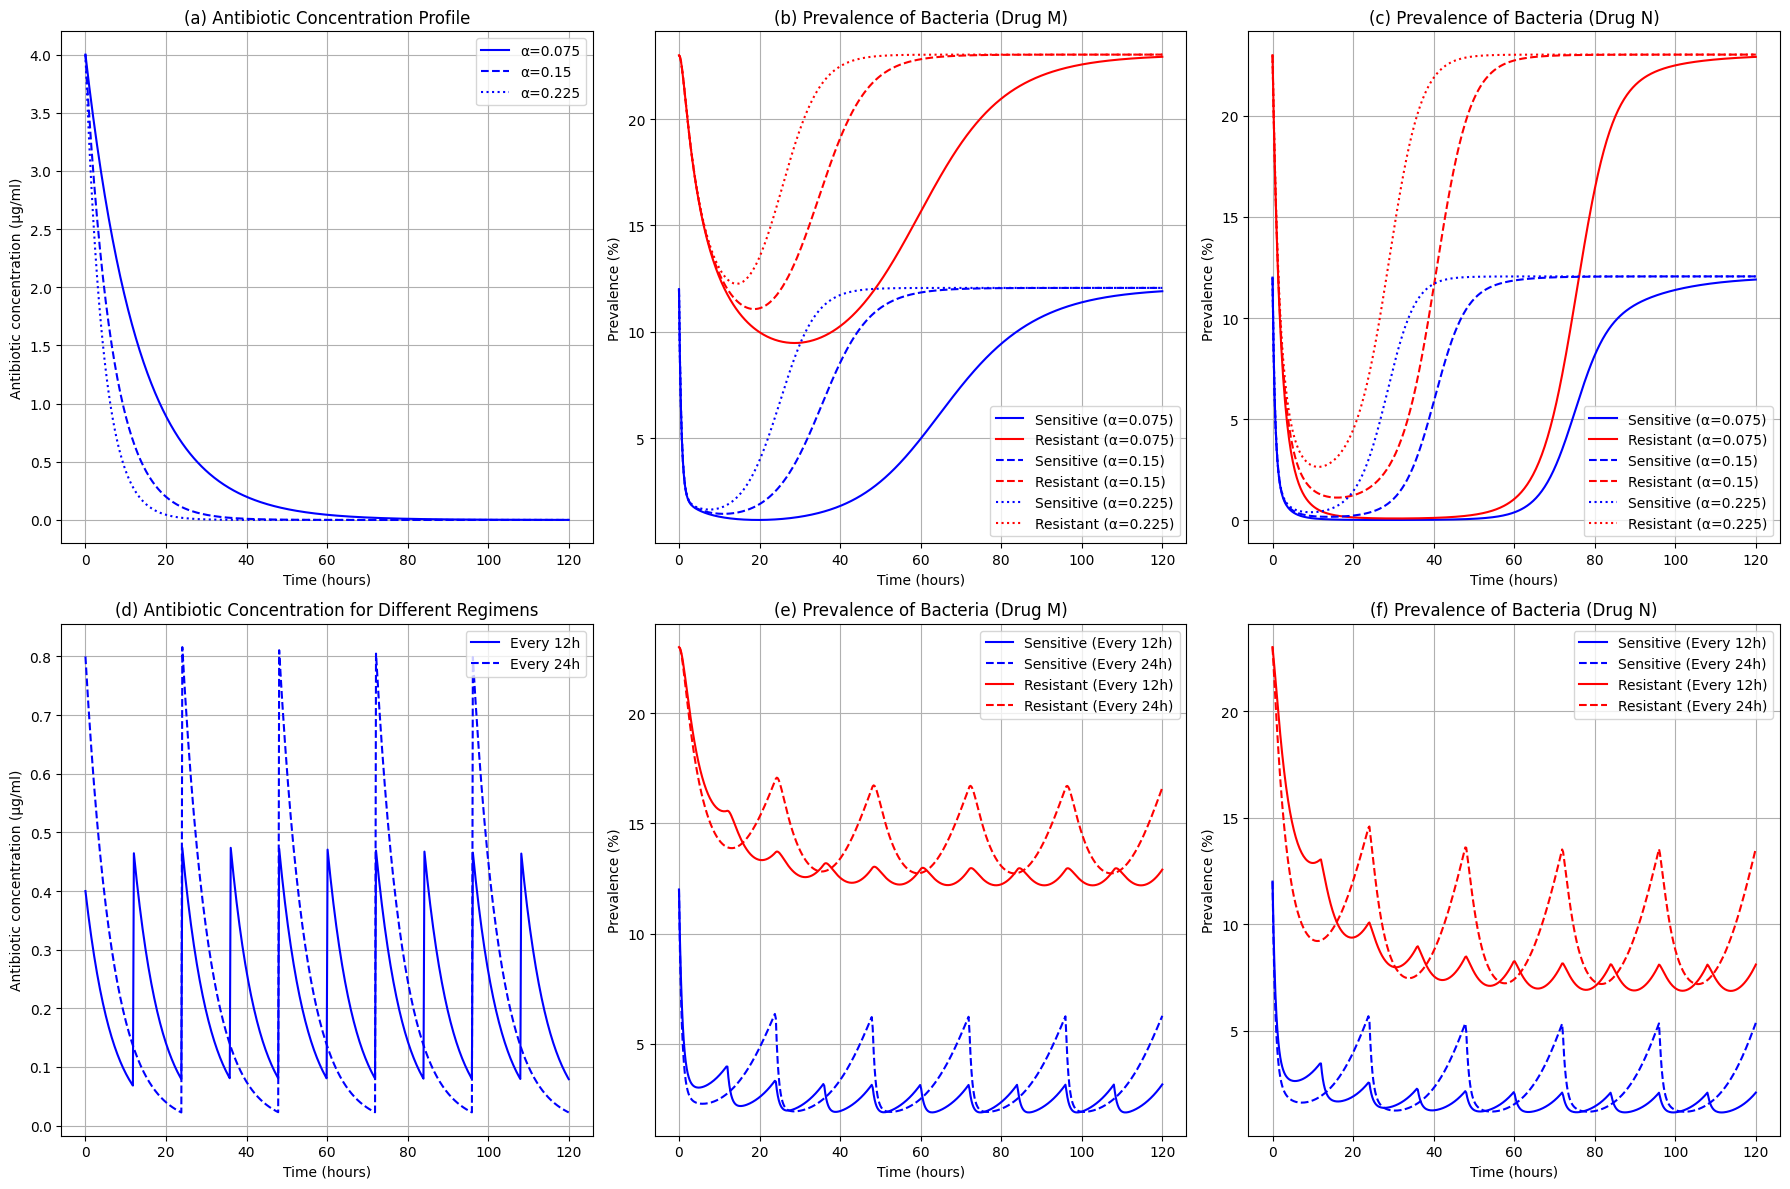

In [51]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define parameters
params = {
    'gS': 1.0,
    'gR': 0.65,
    'K': 1e9,
    'lambda': 0.7,
    'p': 0.5,
    'd': 0.5,
    'ES_max': 1.5,
    'ER_max': 1.1,
    'AS_50': 0.25,
    'AR_50': 5.0,
    'A0': 4,
    'tau': 12
}

def mu_i(Emax, A, A50):
    return Emax * A / (A50 + A)

def A_t(t, A0, alpha, tau):
    if tau == -1:
        return A0 * np.exp(-alpha * t)
    dose_per_admin = A0 / (120 // tau)
    return sum(dose_per_admin * np.exp(-alpha * (t - n * tau)) * (t >= n * tau) for n in range(120 // tau))

def model(y, t, params, alpha, tau, antibiotic):
    S, R = y
    A = A_t(t, params['A0'], alpha, tau)
    mu_S = mu_i(params['ES_max'], A, params['AS_50']) if antibiotic in ['N', 'M'] else 0
    mu_R = mu_i(params['ER_max'], A, params['AR_50']) if antibiotic == 'N' else 0
    dSdt = (params['gS'] * (1 - (S + R) / params['K']) * S) - (params['lambda'] * S * R / (S + R)) + ((params['p']/2) * params['gR'] * R) - ((mu_S + params['d']) * S)
    dRdt = (params['gR'] * (1 - (S + R) / params['K']) * R) + (params['lambda'] * S * R / (S + R)) - ((params['p']/2) * params['gR'] * R) - ((mu_R + params['d']) * R)
    return [dSdt, dRdt]
print(params)
S0, R0 = 1.2e8, 2.3e8
initial_conditions = [S0, R0]
time = np.linspace(0, 120, 500)
alphas = [0.075, 0.15, 0.225]
styles = ['-', '--', ':']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# (a) Antibiotic concentration profile
for alpha, style in zip(alphas, styles):
    axes[0, 0].plot(time, [A_t(t, params['A0'], alpha, -1) for t in time], linestyle=style, label=f'α={alpha}', color='blue')
axes[0, 0].set_title("(a) Antibiotic Concentration Profile")
axes[0, 0].set_xlabel("Time (hours)")
axes[0, 0].set_ylabel("Antibiotic concentration (μg/ml)")
axes[0, 0].legend()
axes[0, 0].grid()

# (b) Prevalence of bacteria when drug M is used
for alpha, style in zip(alphas, styles):
    solution = odeint(model, initial_conditions, time, args=(params, alpha, -1, 'M'))
    S, R = solution[:, 0], solution[:, 1]
    axes[0, 1].plot(time, S / params['K'] * 100, linestyle=style, color='blue', label=f'Sensitive (α={alpha})')
    axes[0, 1].plot(time, R / params['K'] * 100, linestyle=style, color='red', label=f'Resistant (α={alpha})')
axes[0, 1].set_title("(b) Prevalence of Bacteria (Drug M)")
axes[0, 1].set_xlabel("Time (hours)")
axes[0, 1].set_ylabel("Prevalence (%)")
axes[0, 1].legend()
axes[0, 1].grid()

# (c) Prevalence of bacteria when drug N is used
for alpha, style in zip(alphas, styles):
    solution = odeint(model, initial_conditions, time, args=(params, alpha, -1, 'N'))
    S, R = solution[:, 0], solution[:, 1]
    axes[0, 2].plot(time, S / params['K'] * 100, linestyle=style, color='blue', label=f'Sensitive (α={alpha})')
    axes[0, 2].plot(time, R / params['K'] * 100, linestyle=style, color='red', label=f'Resistant (α={alpha})')
axes[0, 2].set_title("(c) Prevalence of Bacteria (Drug N)")
axes[0, 2].set_xlabel("Time (hours)")
axes[0, 2].set_ylabel("Prevalence (%)")
axes[0, 2].legend()
axes[0, 2].grid()

# (d) Antibiotic regimens concentration profiles
A_12h = [A_t(t, params['A0'], 0.15, 12) for t in time]
A_24h = [A_t(t, params['A0'], 0.15, 24) for t in time]
axes[1, 0].plot(time, A_12h, label="Every 12h", color='blue', linestyle=styles[0])
axes[1, 0].plot(time, A_24h, label="Every 24h", color='blue', linestyle=styles[1])
axes[1, 0].set_title("(d) Antibiotic Concentration for Different Regimens")
axes[1, 0].set_xlabel("Time (hours)")
axes[1, 0].set_ylabel("Antibiotic concentration (μg/ml)")
axes[1, 0].legend()
axes[1, 0].grid()

# (e) Prevalence under different regimens for drug M
solution_12h = odeint(model, initial_conditions, time, args=(params, 0.15, 12, 'M'))
solution_24h = odeint(model, initial_conditions, time, args=(params, 0.15, 24, 'M'))
S_12h, R_12h = solution_12h[:, 0], solution_12h[:, 1]
S_24h, R_24h = solution_24h[:, 0], solution_24h[:, 1]
axes[1, 1].plot(time, S_12h / params['K'] * 100, color='blue', label="Sensitive (Every 12h)")
axes[1, 1].plot(time, S_24h / params['K'] * 100, color='blue', linestyle='--', label="Sensitive (Every 24h)")
axes[1, 1].plot(time, R_12h / params['K'] * 100, color='red', label="Resistant (Every 12h)")
axes[1, 1].plot(time, R_24h / params['K'] * 100, color='red', linestyle='--', label="Resistant (Every 24h)")
axes[1, 1].set_title("(e) Prevalence of Bacteria (Drug M)")
axes[1, 1].set_xlabel("Time (hours)")
axes[1, 1].set_ylabel("Prevalence (%)")
axes[1, 1].legend()
axes[1, 1].grid()

# (f) Prevalence under different regimens for drug N
solution_12h = odeint(model, initial_conditions, time, args=(params, 0.15, 12, 'N'))
solution_24h = odeint(model, initial_conditions, time, args=(params, 0.15, 24, 'N'))
S_12h, R_12h = solution_12h[:, 0], solution_12h[:, 1]
S_24h, R_24h = solution_24h[:, 0], solution_24h[:, 1]
axes[1, 2].plot(time, S_12h / params['K'] * 100, color='blue', label="Sensitive (Every 12h)")
axes[1, 2].plot(time, S_24h / params['K'] * 100, color='blue', linestyle='--', label="Sensitive (Every 24h)")
axes[1, 2].plot(time, R_12h / params['K'] * 100, color='red', label="Resistant (Every 12h)")
axes[1, 2].plot(time, R_24h / params['K'] * 100, color='red', linestyle='--', label="Resistant (Every 24h)")
axes[1, 2].set_title("(f) Prevalence of Bacteria (Drug N)")
axes[1, 2].set_xlabel("Time (hours)")
axes[1, 2].set_ylabel("Prevalence (%)")
axes[1, 2].legend()
axes[1, 2].grid()

plt.tight_layout()
plt.show()

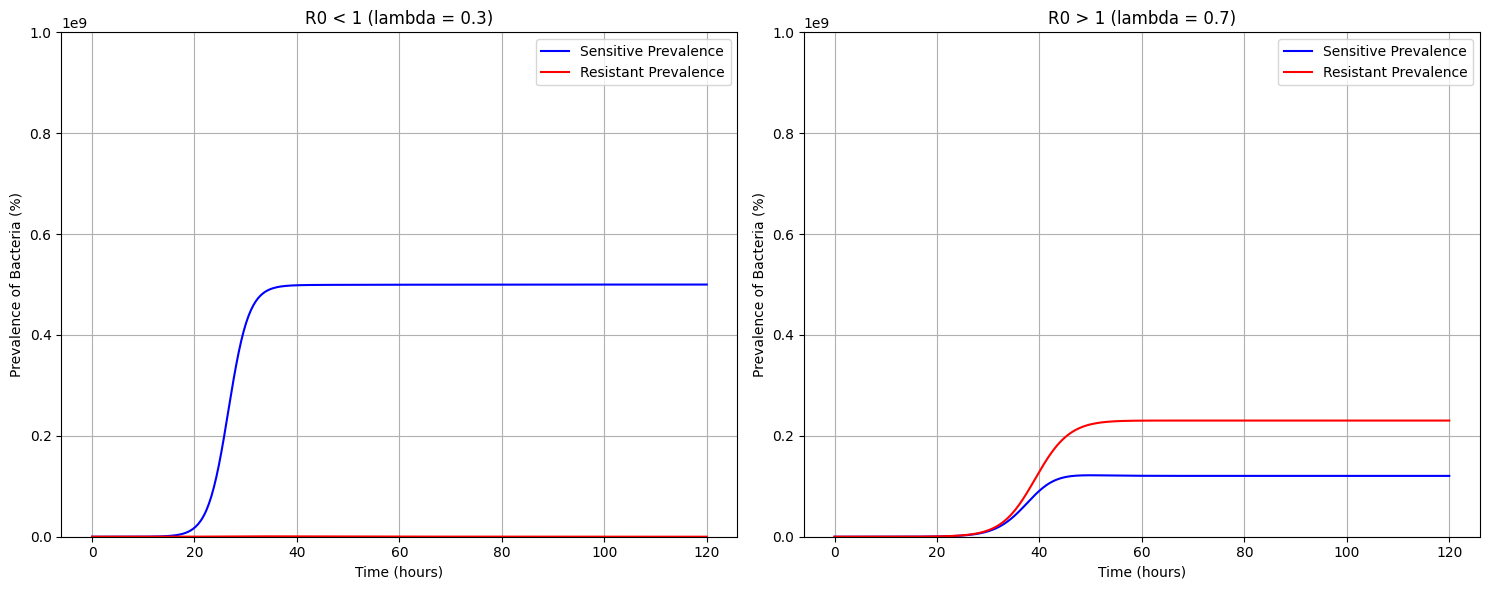

In [52]:
# Initial conditions
S0 = 1e3   # Initial sensitive bacteria
R0 = 1e3   # Initial resistant bacteria
initial_conditions = [S0, R0]

# Time span for the simulation (e.g., 0 to 120 hours)
time = np.linspace(0, 120, 500)
# --- Recreate Figure 2 ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
params['p'] = 0.5
K = 1e9  # Define your K parameter
params['A0'] = 0  # Initial dose (μg/ml)
params['tau'] = -1  # No repeated doses
params['alpha'] = 0.15  # Antibiotic elimination rate (1/h)

# 2a: R0 < 1 (lambda = 0.3)
params['lambda'] = 0.3
solution = odeint(model, initial_conditions, time, args=(params, alpha, -1, 'O'))
S, R = solution[:, 0], solution[:, 1]
axes[0].plot(time, S , label="Sensitive Prevalence", color="blue")
axes[0].plot(time, R , label="Resistant Prevalence", color="red")
axes[0].set_ylim(0, K)  # Set y-axis limit
axes[0].set_title("R0 < 1 (lambda = 0.3)")
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("Prevalence of Bacteria (%)")
axes[0].legend()
axes[0].grid()

# 2b: R0 > 1 (lambda = 0.7)
params['lambda'] = 0.7
solution = odeint(model, initial_conditions, time, args=(params, alpha, -1, 'O'))
S, R = solution[:, 0], solution[:, 1]
axes[1].plot(time, S , label="Sensitive Prevalence", color="blue")
axes[1].plot(time, R , label="Resistant Prevalence", color="red")
axes[1].set_ylim(0, K)  # Set y-axis limit
axes[1].set_title("R0 > 1 (lambda = 0.7)")
axes[1].set_xlabel("Time (hours)")a
axes[1].set_ylabel("Prevalence of Bacteria (%)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

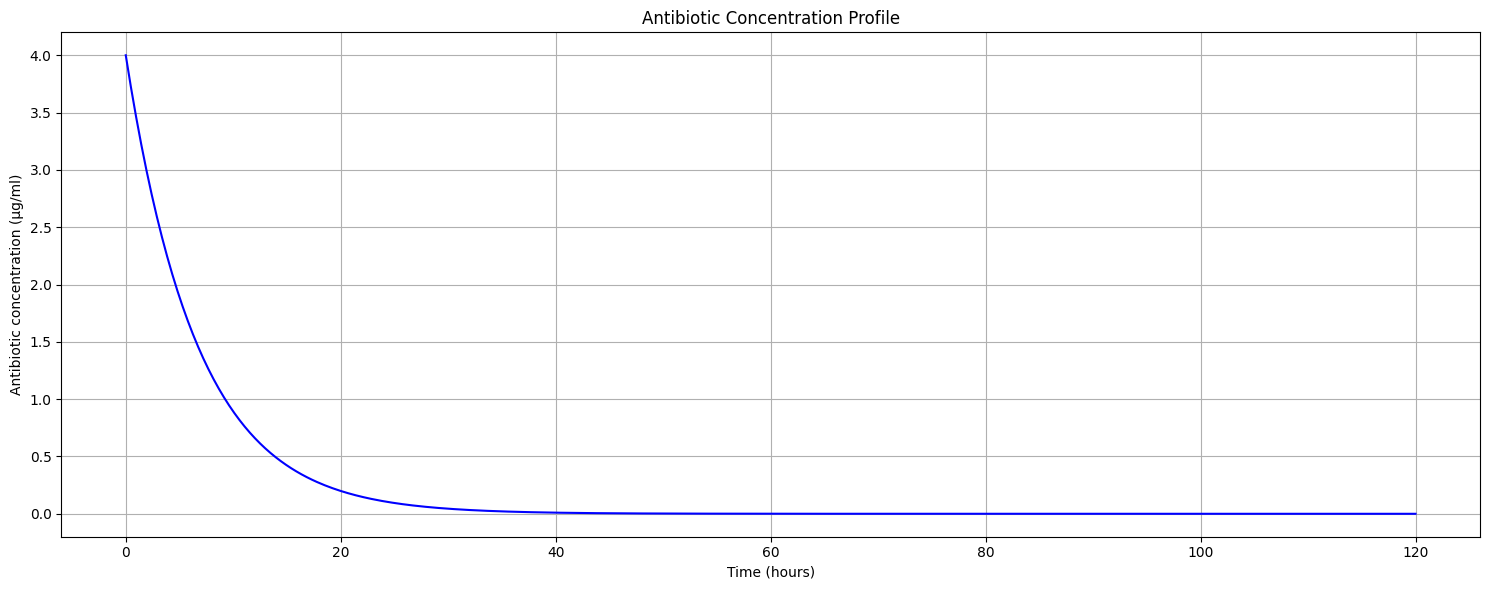

In [55]:
# --- Recreate Figure 4 ---
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# 4a: Antibiotic concentration profile
A0 = 4  # Initial dose (μg/ml)
tau = -1  # Period for administering antibiotic doses
antibiotic_levels = [A_t(t, A0, params['alpha'], tau) for t in time]

# Use `axes` directly instead of `axes[0]`
axes.plot(time, antibiotic_levels, color="blue")
axes.set_title("Antibiotic Concentration Profile")
axes.set_xlabel("Time (hours)")
axes.set_ylabel("Antibiotic concentration (μg/ml)")
axes.grid()

plt.tight_layout()
plt.show()